# Bank Customer Churn
This notebook is dedicated to leveraging various Python-based machine learning and data science libraries. The goal is to construct a robust machine learning model capable of predicting customer churn based on their historical behavior and attributes.

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
import warnings
warnings.filterwarnings('ignore')

### Importing Dataset

In [2]:
train_data = pd.read_csv("Dataset/Churn_Modelling.csv")

In [3]:
train_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
train_data.shape

(10000, 14)

#### Checking the duplicate row

In [5]:
train_data.duplicated().sum()

0

#### Checking for null values

In [6]:
train_data.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

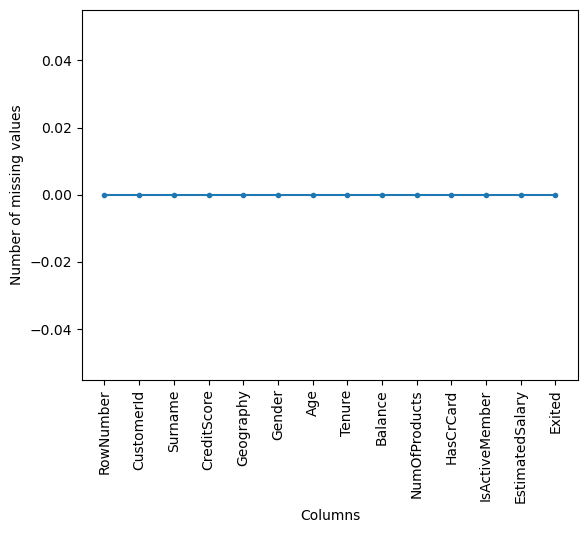

In [7]:
plt.plot(train_data.isnull().sum(),'.-')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.show()

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [9]:
train_data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Data Cleaning

#### Data is imbalanced 

In [10]:
train_data['Exited'].value_counts()/len(train_data['Exited'])* 100

0    79.63
1    20.37
Name: Exited, dtype: float64

In [11]:
train_data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Converting tenure to bins

In [12]:
train_data['Tenure'].nunique()

11

In [13]:
train_data['Tenure'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: Tenure, dtype: int64

In [14]:
labels=["{0} - {1}".format(i,i+2) for i in range(1,11,2)]
train_data['Tenure_grp']=pd.cut(train_data['Tenure'],range(1,12,2),right=False,labels=labels)

In [15]:
train_data['Tenure_grp'].value_counts()

1 - 3     2083
7 - 9     2053
3 - 5     1998
5 - 7     1979
9 - 11    1474
Name: Tenure_grp, dtype: int64

In [16]:
#similarly making age grp bins
labels=["{0} - {1}".format(i,i+5) for i in range(18,93,5)]
train_data['Age_grp']=pd.cut(train_data['Age'],range(18,94,5),right=False,labels=labels)

In [17]:
train_data['Age_grp'].value_counts()

33 - 38    2297
38 - 43    2019
28 - 33    1770
43 - 48    1184
23 - 28     794
48 - 53     670
53 - 58     385
58 - 63     296
18 - 23     226
63 - 68     167
68 - 73     107
73 - 78      61
78 - 83      17
83 - 88       4
88 - 93       3
Name: Age_grp, dtype: int64

### Removing irrelevant columns such as name and customerid

In [18]:
train_data.drop(['RowNumber','CustomerId','Surname','Tenure','Age'],inplace=True,axis=1)

In [19]:
train_data.head()

,CreditScore,Geography,Gender,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_grp,Age_grp
0,619,France,Female,0.00,1,1,1,101348.88,1,1 - 3,38 - 43
1,608,Spain,Female,83807.86,1,0,1,112542.58,0,1 - 3,38 - 43
2,502,France,Female,159660.80,3,1,0,113931.57,1,7 - 9,38 - 43
3,699,France,Female,0.00,2,0,0,93826.63,0,1 - 3,38 - 43
4,850,Spain,Female,125510.82,1,1,1,79084.10,0,1 - 3,43 - 48


### Model Training

In [20]:
X = train_data.drop('Exited', axis=1)
Y = train_data['Exited']

In [21]:
ct=ColumnTransformer(
    [
        ('ohe',OneHotEncoder(sparse=False,drop='first'),['Geography','Gender','Tenure_grp','Age_grp']),
        ('sc',StandardScaler(),['CreditScore','Balance','EstimatedSalary',]),
    ],remainder='passthrough'
)

In [22]:
X_new = ct.fit_transform(X)

In [23]:
X_new

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 3., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 2., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [24]:
sm = SMOTE(random_state=42)
X_res, Y_res = sm.fit_resample(X_new, Y)

### Train test split

In [25]:
x_train,x_test,y_train,y_test=train_test_split(X_res,Y_res,test_size=0.2,random_state=42)

In [26]:
x_train.shape, x_test.shape

((12740, 28), (3186, 28))

### Logistic Regression Classifier

In [27]:
lr_classifier = LogisticRegression()
lr_classifier.fit(x_train, y_train)
y_pred = lr_classifier.predict(x_test)
accuracy = cross_val_score(lr_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 73.54644781279165
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1633
           1       0.73      0.72      0.72      1553

    accuracy                           0.73      3186
   macro avg       0.73      0.73      0.73      3186
weighted avg       0.73      0.73      0.73      3186



### Random Forest Classifier

In [28]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = cross_val_score(rf_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 91.32313959916866
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1633
           1       0.92      0.90      0.91      1553

    accuracy                           0.91      3186
   macro avg       0.91      0.91      0.91      3186
weighted avg       0.91      0.91      0.91      3186



### GradientBoosting Classifier

In [29]:
gb_classifier = GradientBoostingClassifier()
gb_classifier.fit(x_train, y_train)
y_pred = gb_classifier.predict(x_test)
accuracy = cross_val_score(gb_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 87.19157499302777
              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1633
           1       0.89      0.86      0.88      1553

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



### Therefore RandomForest provide the best accuracy

### Random search CV

In [30]:
distributions = dict(n_estimators=range(50,150,10),
                      criterion=['gini', 'entropy', 'log_loss'],
                     min_samples_split=range(0,6,2),
                     max_features=['sqrt', 'log2', None]
                    )
rs=RandomizedSearchCV(rf_classifier,distributions,random_state=42)

In [31]:
search = rs.fit(x_train,y_train)

In [32]:
search.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'max_features': 'log2',
 'criterion': 'gini'}

In [33]:
rf_classifier = RandomForestClassifier(
    n_estimators = 120,
 min_samples_split= 2,
 max_features='log2',
 criterion='entropy'
)
rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)
accuracy = cross_val_score(rf_classifier,X_res,Y_res)

print("Validation Accuracy:", np.mean(accuracy)*100)
print(classification_report(y_test, y_pred))

Validation Accuracy: 91.32944662726746
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1633
           1       0.92      0.91      0.91      1553

    accuracy                           0.92      3186
   macro avg       0.92      0.92      0.92      3186
weighted avg       0.92      0.92      0.92      3186

